# Homework №4 (Sennikov Andrey)
Решить задачу классификации инфаркта по записям PPG.

1) ML-решение - на ваше усмотрение + 2 балла. Топ-5 получат +1 балл
2) Попробовать фильтровать сигнал, чтобы искать качественные высокоуровневые фичи. По фичам построить пороговый классификатор,
сравнить его с ML-решением.

2.1) Попробовать фильтровать сигнал при помощи рекуррентных фильтров. + 1 балл

2.2) Попробовать фильтровать сигнал при помощи сверточные оконные фильтры (np.convolve или torch.conv). + 1 балл

2.3) Попробовать фильтровать сигнал при помощи преобразования Фурье. + 1 балл

   Каждым из способов попробовать извлечь фичи, посмотреть точность.

Оценка: 4 базовая + улучшения.

Дедлайн: 6 февраля 23:59

In [139]:
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

from scipy.signal import butter, lfilter, freqz

import time

In [140]:
path = kagglehub.dataset_download("ucimachinelearning/photoplethysmography-ppg-dataset")

print("Path to dataset files:", path)

data = pd.read_csv("/kaggle/input/photoplethysmography-ppg-dataset/PPG_Dataset.csv")

Path to dataset files: /kaggle/input/photoplethysmography-ppg-dataset


In [141]:
print(data.shape)
data.head()

(2576, 2001)


,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,Label
0,-0.015552,0.016963,0.013575,0.027204,0.068154,0.129259,0.127915,0.345174,0.197811,0.167651,...,-0.426464,-0.346976,-0.132168,-0.252098,-0.241969,-0.134235,-0.091327,-0.081713,-0.057693,MI
1,0.002323,0.002754,0.022539,0.228807,0.107751,0.034439,0.086007,0.155667,0.163327,0.223759,...,-0.169345,-0.356808,-0.338996,-0.292489,-0.152872,-0.156076,-0.103265,-0.041579,-0.044272,MI
2,0.050481,-0.339781,0.265111,0.045092,0.040086,0.087173,0.092814,0.099586,-0.143305,0.164186,...,-0.401426,-0.402333,-0.373426,-0.303710,0.008599,-0.180633,-0.143135,-0.084758,0.060668,MI
3,0.023882,0.016561,0.248547,0.054567,0.128032,0.085954,0.107359,0.207137,0.174547,-0.100118,...,-0.390700,-0.353882,-0.294014,-0.267005,-0.242258,-0.186946,-0.173718,0.101331,0.063555,MI
4,-0.058591,0.171551,0.057262,0.270869,0.138357,0.078509,0.062504,0.104447,0.134795,0.194248,...,-0.391598,-0.334490,-0.326873,-0.249881,-0.210052,-0.194763,-0.415365,0.015432,0.010321,MI


In [142]:
X = data.drop('Label', axis=1)
y = data['Label']

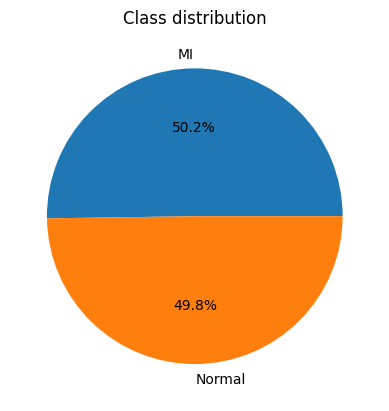

In [143]:
class_counts = data['Label'].value_counts()

class_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Class distribution')
plt.ylabel('')
plt.show()

# 1. ML-models

In [144]:
results = pd.DataFrame(columns=['model', 'accuracy', 'process time, sec'])

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1803, 2000) (1803,)
(773, 2000) (773,)


In [146]:
def calculate_metrics(model):
    start_time = time.time()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return round(accuracy, 4), time.time() - start_time

In [147]:
model_name = LogisticRegression()
accuracy, time_processing = calculate_metrics(model_name)
print(f"By {model_name} accuracy : {accuracy}")

results.loc[results.shape[0] + 1] = [str(model_name), accuracy, time_processing]

By LogisticRegression() accuracy : 0.9728


In [148]:
model_name = DecisionTreeClassifier()
accuracy, time_processing = calculate_metrics(model_name)
print(f"By {model_name} accuracy : {accuracy}")

results.loc[results.shape[0] + 1] = [str(model_name), accuracy, time_processing]

By DecisionTreeClassifier() accuracy : 0.9444


In [149]:
model_name = RandomForestClassifier()
accuracy, time_processing = calculate_metrics(model_name)
print(f"By {model_name} accuracy : {accuracy}")

results.loc[results.shape[0] + 1] = [str(model_name), accuracy, time_processing]

By RandomForestClassifier() accuracy : 0.9728


In [150]:
results

,model,accuracy,"process time, sec"
1,LogisticRegression(),0.9728,0.241204
2,DecisionTreeClassifier(),0.9444,7.948473
3,RandomForestClassifier(),0.9728,9.097956


The best results are achieved with the help of `LogisticRegression()` and `RandomForestClassifier()` models, but `LogisticRegression()` has faster process_time.

# 2. Signal filtering

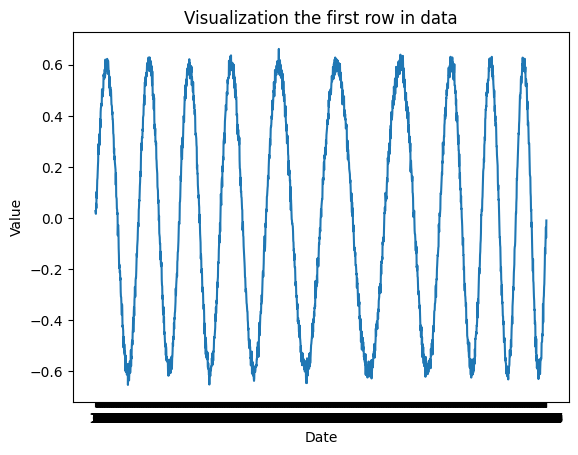

In [151]:
plt.plot(X_train.iloc[0])
plt.title('Visualization the first row in data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [ ]:
signal = np.array(X_train.loc[1])
fs = len(signal)
t = list(X_train.columns)

In [171]:
def threshold_classifier(features, threshold):
    preds = (features < threshold).astype(int)
    return  ['MI' if i == 0 else 'Normal' for i in preds]

def extract_features(signal):
    return np.max(signal) - np.min(signal)

In [153]:
def butterlowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butterlowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [154]:
cutoff = 10
filtered_signal = lowpass_filter(signal, cutoff, fs)

In [155]:
window_size = 5
kernel = np.ones(window_size) / window_size
convolved_signal = np.convolve(signal, kernel, mode='same')

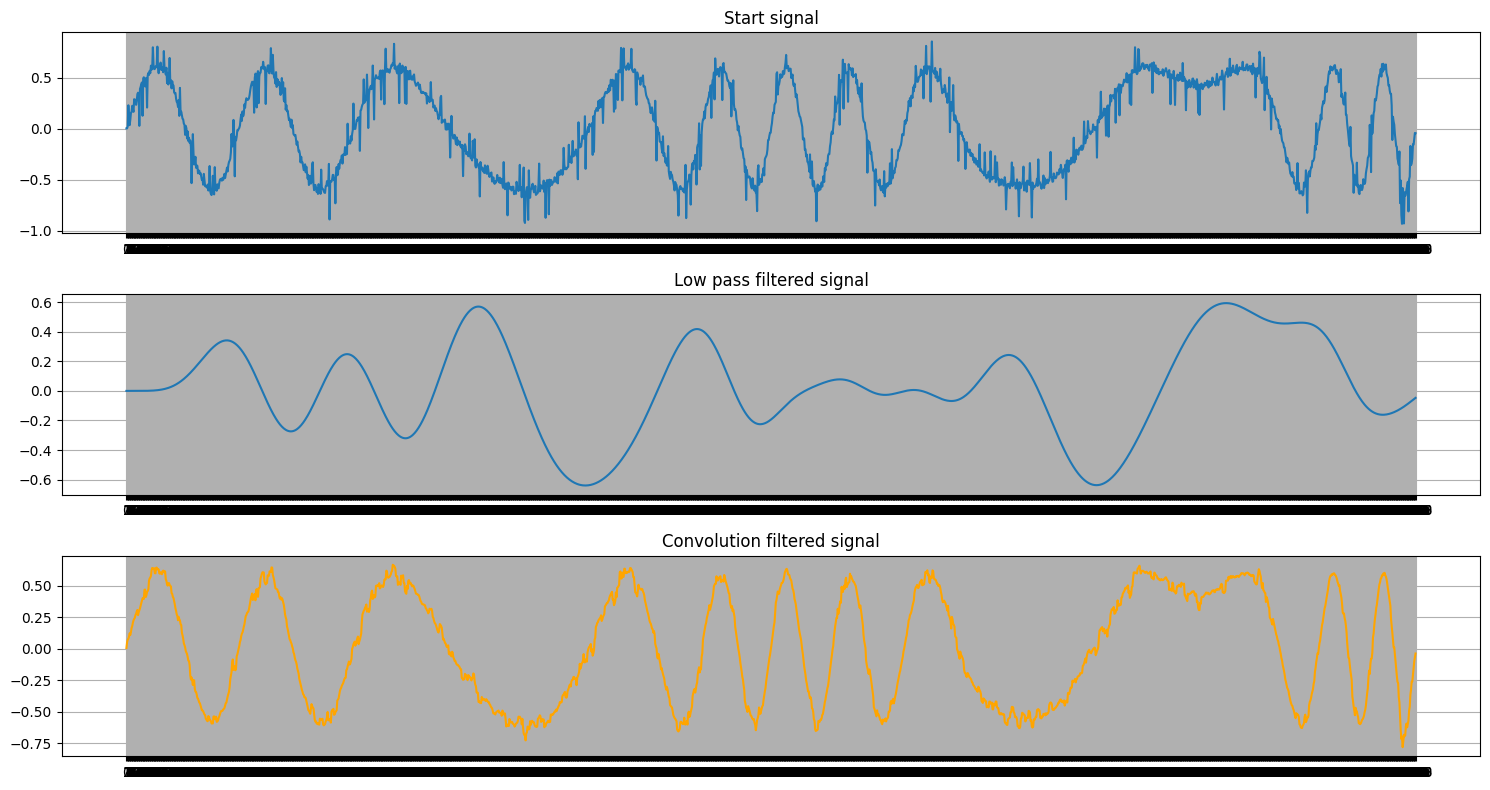

In [168]:
plt.figure(figsize=(15, 8))

plt.subplot(3, 1, 1)
plt.title('Start signal')
plt.plot(t, signal)
plt.grid()

plt.subplot(3, 1, 2)
plt.title('Low pass filtered signal')
plt.plot(t, filtered_signal)
plt.grid()

plt.subplot(3, 1, 3)
plt.title('Convolution filtered signal')
plt.plot(t, convolved_signal, color='orange')
plt.grid()

plt.tight_layout()
plt.show()

In [178]:
threshold = 0.5
features = convolved_signal > threshold
labels = np.where(features, 1, 0)
true_labels = np.where(signal > 0, 1, 0)

In [179]:
accuracy = accuracy_score(true_labels, labels)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.67


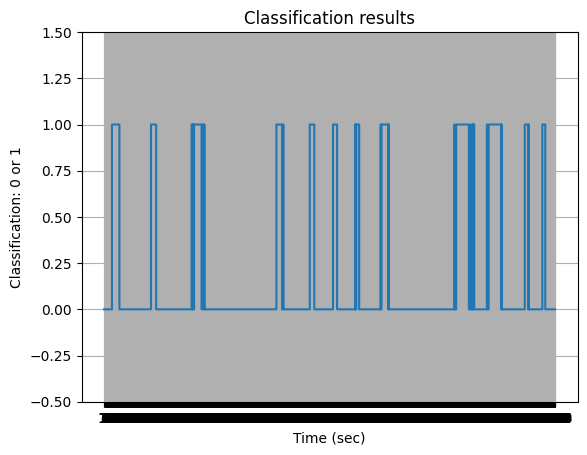

In [170]:
plt.figure()
plt.title('Classification results')
plt.plot(t, labels, drawstyle='steps-post')
plt.ylim(-0.5, 1.5)
plt.grid()
plt.xlabel('Time (sec)')
plt.ylabel('Classification: 0 or 1')
plt.show()